In [1]:
import sys
sys.path.append("../lib/")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

from DalitzModel import *
from BWRes import *

%matplotlib inline
plt.rc('animation', html='html5')
plt.rc('text', usetex=True)
plt.rc('font', size=18)

# Auxiliary functions

The plot_ddist function draws a 2D hist for a Dalitz distribution

In [2]:
def plot_ddist(mab, mbc, bins=200, num=None):
    """ Scatter plot of Dalitz distribution """
    fig = plt.figure(num=num, figsize=(8,6))
    ax = fig.add_subplot(111)
    hist = ax.hist2d(mab, mbc, bins=bins, cmap=plt.cm.PuBu)
    fig.colorbar(hist[3], ax=ax, pad=0.02)

The phsp_edge function calculates edges of the kinematically allowed phase space

In [3]:
def phsp_edge(phsp, rtype1, rtype2):
    """ Calculate phase space edges """
    mr1_min, mr1_max = phsp.mass_sq_range[rtype1]
    mr1_space = np.linspace(mr1_min, mr1_max, 1000)
    mr2_mins, mr2_maxs = phsp.mr_sq_range(rtype2, mr1_space, rtype1)
    mr1 = np.concatenate([mr1_space, mr1_space[::-1]])
    mr2 = np.concatenate([mr2_mins, mr2_maxs[::-1]])
    return [mr1, mr2]

The show_phase_space function calls the phsp_edge function and draws kinematically allowed phase space

In [4]:
def show_phase_space(phsp, rtype1, rtype2, num=None, color=None):
    """ Plot phase space edge """
    if color is None:
        color = 'blue'
    mr1, mr2 = phsp_edge(phsp, rtype1, rtype2)
    mr1_range = max(mr1) - min(mr1)
    mr2_range = max(mr2) - min(mr2)
    fig = plt.figure(num=num)
    plt.plot(mr1, mr2, linestyle='-', color=color)
    plt.gca().set_xlabel(r'$m^{2}_{\mathrm{' + rtype1 + r'}}\ (GeV^{2}/c^{4})$')
    plt.gca().set_ylabel(r'$m^{2}_{\mathrm{' + rtype2 + r'}}\ (GeV^{2}/c^{4})$')
    plt.axis('equal')
    plt.tight_layout()
    plt.xlim(0, 1.05*max(mr1))
    plt.ylim(0, 1.05*max(mr2))

In [5]:
def plot_density_countours(msq1g, msq2g, dens, num=None, figsize=None, nlevels=25, cmap=plt.cm.PuBu):
    fig = plt.figure(num=num, figsize=figsize)
    levels = np.linspace(0, max(dens.flatten()), nlevels)
    CS = plt.contourf(msq1g, msq2g, dens, cmap=cmap, levels=levels)
    plt.colorbar(CS)

In [6]:
def projections(mab_sq, mac_sq, mbc_sq):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 3))
    ax1.hist(np.sqrt(mab_sq), bins=100, normed=True, edgecolor = "none", color=['steelblue']);
    ax2.hist(np.sqrt(mac_sq), bins=100, normed=True, edgecolor = "none", color=['steelblue']);
    ax3.hist(np.sqrt(mbc_sq), bins=100, normed=True,edgecolor = "none", color=['steelblue']);

## Model initialization
Define a $D^0 \to K_S^0 \pi^+ \pi^-$ decay model with two resonances: $\rho(770)$ and $K^*(892)$

In [7]:
model = DalitzModel(.475, .135, .135, 1.865)
model.add_bw('rho(770)', .770, .1490, 1, 'BC')
model.add_bw('K*', .89166, 0.0508, 1, 'AB', 0.638*np.exp(1j*np.radians(133.2)))

## Density contour plot

[[0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]
 [0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]
 [0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]
 ...
 [0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]
 [0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]
 [0.3721    0.3826253 0.3931506 ... 2.9718494 2.9823747 2.9929   ]]
(250, 250)


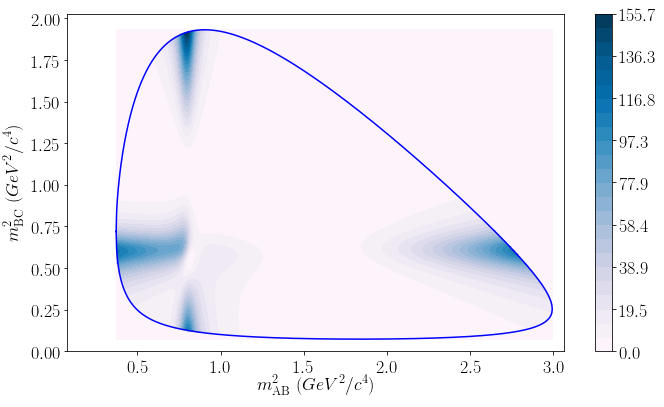

In [8]:
msq1g, msq2g, dens = model.grid_dens('AB', 'BC', 250)
plot_density_countours(msq1g, msq2g, dens, 6, (10, 6))
show_phase_space(model, 'AB', 'BC', 6, 'blue')

## Sampling Dalitz distribution
### Neumann's method

In [9]:
majorant = model.assess_majorant()
majorant

AttributeError: 'DalitzModel' object has no attribute 'assess_majorant'

$10^6$ events are generated in about 24 seconds with the Neumann's method:

In [ ]:
%%time
rtype1, rtype2 = 'AB', 'BC'
smpl = model.sample(10**6, rtype1, rtype2, True)
mab_sq, mbc_sq = smpl[rtype1], smpl[rtype2]

In [ ]:
smpl

In [ ]:
smpl['AB'].shape

In [ ]:
plot_ddist(mab_sq, mbc_sq, 400, 5)
show_phase_space(model, rtype1, rtype2, 5)

In [ ]:
usmpl = model.uniform_sample('AB', 'BC', 10**6, None, True)
model.area

In [ ]:
mac_sq = model.third_mass_sq(mab_sq, mbc_sq)
plot_ddist(mab_sq, mac_sq, 400, 5)
show_phase_space(model, 'AB', 'AC', 5)

In [ ]:
projections(mab_sq, mac_sq, mbc_sq)

### Markov chain MC method
Now we generate $10^6$ events in about 5 seconds

In [ ]:
%%time
rtype1, rtype2 = 'AB', 'BC'
mcmc_smpl = model.mcmc_sample(10**7, rtype1, rtype2, 0.1, 32)
mab_sq, mbc_sq = mcmc_smpl[rtype1], mcmc_smpl[rtype2]

In [ ]:
projections(mab_sq, mac_sq, mbc_sq)

## Animated interference

In [ ]:
from matplotlib import animation

In [ ]:
FIG = plt.figure(num=9, figsize=(9, 6))
AXES = plt.axes()
show_phase_space(model, 'AB', 'BC', 9, 'blue')
plt.grid()
plt.title(r'$\rho(770)$ -- $K^*(892)$ interference')
plt.close()

In [ ]:
ims = []
for i in range(200):
    model.rdict['K*']['ampl'] *= np.exp(1j * np.pi / 100)
    msq1g, msq2g, dens = model.grid_dens('AB', 'BC')
    levels = np.linspace(0, max(dens.flatten()), 25)
    cont = AXES.contourf(msq1g, msq2g, dens, cmap=plt.cm.PuBu, levels=levels)
    add_arts = cont.collections
    text = ''
    te = AXES.text(90, 90, str(text))
    an = AXES.annotate(str(text), xy=(0.45, 1.05), xycoords='axes fraction')
    ims.append(add_arts + [te,an])
    if (i+1) % 10 == 0:
        print 'frame {} / {}'.format(i+1, 200)

In [ ]:
ani = animation.ArtistAnimation(FIG, ims, interval=20, blit=True)
ani